# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам

# <center>Неделя 3. Визуальный анализ данных и построение признаков

## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#import pixiedust
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import timeit
import datetime
#from datetime import datetime

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [5]:
def prepare_train_set_with_fe(path_to_csv_files, path_pckl_file, feature_names, session_length=10):
    
    # Str numeration for site
    #site_numeration = ['site' + str(index + 1) for index in range(session_length)] + \
    #              ['time_diff' + str(index + 1) for index in range(session_length - 1)] + \
    #              ['unique_sites', 'start_hour', 'day_of_week','user_id']
    site_numeration = feature_names    
    # Ininitial dataframe and user id
    resultData = pd.DataFrame(columns=(site_numeration))
    #all_data_result = []
    user_id = 0
    
    def incomplete_condition(user_data_eval, session_length):
        '''Condition for determining incomplete session'''
        if not user_data_eval.shape[0] % session_length == 0:   
            # Fill zeros for incomplete session
            for index in range( user_data_eval.shape[0], (user_data_eval.shape[0] // session_length + 1)*session_length ):
                user_data_eval.loc[index] = [0, 0]
            
    def adding_algorytm(user_data):
        '''adding sessions + feacheres to the dataframe'''
    
        nonlocal user_id, resultData
        #User id value
        user_id = user_id + 1 
        # Copy of daraframe for main algorytm
        user_data_eval = user_data.copy() 
           
        #Time convert to datatime
        user_data_eval['timestamp'] = user_data_eval['timestamp'].\
            apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ))
        # Condition for determining incomplete session
        incomplete_condition(user_data_eval, session_length)
        # Main alhortm of replacing str sites for numbers
        session_items = int( user_data_eval.shape[0] / session_length )
        # sites
        all_sessions = user_data_eval['site'].values.reshape(session_items,-1)
        # time
        #all_time_sessions = user_data_eval['timestamp'].values.reshape(session_items,-1)
        all_time_sessions = user_data_eval['timestamp'].values.astype('datetime64[s]')\
                .astype(datetime.datetime).reshape(session_items,-1)
        all_time_sessions_null = [*map(np.trim_zeros,all_time_sessions)]
        # Time difference evaluating
        diff_seconds = [*map(lambda session: [(j-i).seconds for i, j in zip(session, session[1:])],\
                             all_time_sessions_null)]
        # Add droped 0 
        for index, items in enumerate(diff_seconds):
            if len(items) != session_length: diff_seconds[index] = (items + [0] * (session_length - 1 - len(items)))
        # Session_timespan
        session_timespan = [*map(lambda x: [(x[-1] - x[0]).seconds], all_time_sessions_null)]
        # Unique sites
        unique_sites = [*map(lambda x: [np.unique(x).shape[0]], map(np.trim_zeros,all_sessions))]
        # Start session
        start_hour = [*map(lambda x: [x[0].hour],all_time_sessions_null)]
        # Day of week
        day_of_week = [*map(lambda x: [x[0].weekday()],all_time_sessions_null)]
        # User ID
        target_user = [ [user_id] for _ in np.arange(session_items)]
        # Stack data
        all_data = np.hstack((all_sessions,diff_seconds,session_timespan,unique_sites,start_hour,day_of_week,target_user))
        # resultData add data
        resultData = resultData.append(pd.DataFrame(data=all_data, columns=site_numeration),ignore_index=True)
        #resultData = resultData.fillna(0) 

    def path_to_csv(path_to_csv_files, PATH_TO_PROJECT='~/geekhubds/HW09'):
        ''' Path to data - csv files'''
        # File operations
        file_quant = len(glob(path_to_csv_files))
        file_names = [file for file in glob(path_to_csv_files)]
        file_length = len(file_names)
        # Import csv files
        user_data = [pd.read_csv(os.path.join(PATH_TO_PROJECT,file)) for file in file_names]
        return user_data
   
    def path_to_plc(path_pckl_file):
        ''' Path to data - pckl file'''
        with open(path_pckl_file, 'rb') as site_freq:
            site_freq = pickle.load(site_freq)
        def replace_func(site_freq):
            '''Creation replace dic from site freq dictionary'''
            return {site:site_freq.get(site)[0] for site in site_freq.keys()}        
        return site_freq, replace_func(site_freq)
           
    # Import csv files 
    user_data = path_to_csv(path_to_csv_files) 

    # Import  dictionary  and replace rule
    site_freq_users_all, replasment = path_to_plc(path_pckl_file)
             
    # Main alhortm of replacing str sites for numbers
    [*map(adding_algorytm, user_data)];

    #Replacing site_id in column and delete NANs
    site_numebers = ['site' + str(index + 1) for index in range(session_length)]   
    for site in site_numebers:
        resultData[site] = resultData[site].map(replasment.get)
    resultData = resultData.fillna(0).astype(int)
    
    return resultData, site_freq_users_all

**Проверим функцию на игрушечном примере.**

In [6]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']

path_to_csv_files = '3users\*'
path_pckl_file = 'site_freq_3users.pkl'

train_data_toy, site_freq_3users = prepare_train_set_with_fe(path_to_csv_files, path_pckl_file, feature_names, session_length=10)
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,2,3,2,4,5,6,7,8,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,1,4,4,4,0,0,0,0,0,0,2,3,55,40705,0,0,0,0,0,40765,2,12,4,1
2,1,2,9,9,2,0,0,0,0,0,287,1184,6278,186,44368,0,0,0,0,52303,3,9,4,2
3,10,4,2,4,2,4,4,6,11,10,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,10,4,2,0,0,0,0,0,0,0,287,1184,40032,0,0,0,0,0,0,41503,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [7]:
%%time
path_to_csv_files = '10users\*'
path_pckl_file = 'site_freq_10users.pkl'
train_data_10users, site_freq_10users = prepare_train_set_with_fe(path_to_csv_files,\
                                                                 path_pckl_file, feature_names, session_length=10)
train_data_10users.head()

Wall time: 7.6 s


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [8]:
%%time
path_to_csv_files = '150users\*'
path_pckl_file = 'site_freq_150users.pkl'
train_data_150users, site_freq_150users = prepare_train_set_with_fe(path_to_csv_files,\
                                                                 path_pckl_file, feature_names, session_length=10)
train_data_150users.head()

Wall time: 1min 20s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [9]:
new_features_10users = train_data_10users.loc[:,'time_diff1':'day_of_week']
new_features_150users = train_data_150users.loc[:,'time_diff1':'day_of_week']

In [10]:
with open(os.path.join('new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join('new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [8]:
print('Median session duration', new_features_10users['session_timespan'].sort_values(ascending=True)\
    .iloc[new_features_10users['session_timespan'].sort_values(ascending=True).size//2])

Median session duration 37


**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [9]:
median_day = new_features_10users['day_of_week'].sort_values(ascending=True)\
    .iloc[new_features_10users['day_of_week'].sort_values(ascending=True).size//2]
week_days = ('Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sanday')

print('Median start day sessions duration:', week_days[ median_day - 1])

Median start day sessions duration: Tuesday


**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [10]:
median_hour = new_features_150users['start_hour'].sort_values(ascending=True)\
    .iloc[new_features_150users['start_hour'].sort_values(ascending=True).size//2]

print('Median start time sessions: ', median_hour,': 00')

Median start time sessions:  13 : 00


**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [11]:
median_unique = new_features_150users['#unique_sites'].sort_values(ascending=True)\
    .iloc[new_features_150users['#unique_sites'].sort_values(ascending=True).size//2]

print('Median value of unique sites:', median_unique)

Median value of unique sites: 7


## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [11]:
# id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
#                33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
id_name_dict = {1: 'Mary-Kate', 2: 'Ashley', 3: 'Lindsey', 4: 'Naomi', 5: 'Avril',
               6: 'Bob', 7: 'Bill', 8: 'John', 9: 'Dick', 10: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,3,4,3,3,4,3,5,3,10,0,0,1,20,1,0,1,0,33,5,8,4,Mary-Kate
1,6,7,8,9,3,10,11,12,13,14,1,0,163,105,0,1,3,3,8,284,10,8,4,Mary-Kate
2,14,4,14,14,15,16,6,17,18,14,0,14,1,242,0,0,1,0,0,258,7,8,4,Mary-Kate
3,19,20,19,14,14,14,14,21,22,23,2,1,0,1,25,1,0,0,0,30,6,8,4,Mary-Kate
4,24,14,15,25,26,27,28,29,30,29,1,0,1,1,1,0,1,1,0,6,9,8,4,Mary-Kate


**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

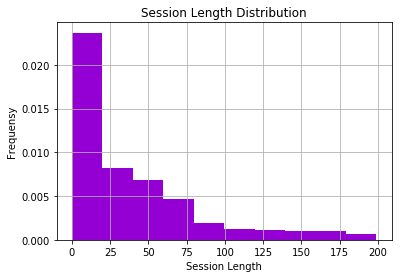

In [12]:
fig, axs = plt.subplots()
axs.grid(True)

plotData = train_data_10users[train_data_10users.session_timespan < 200]['session_timespan']

plt.hist(plotData, bins = 10, color='darkviolet', density=True);
plt.title('Session Length Distribution');
plt.ylabel('Frequensy');
plt.xlabel('Session Length');


**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

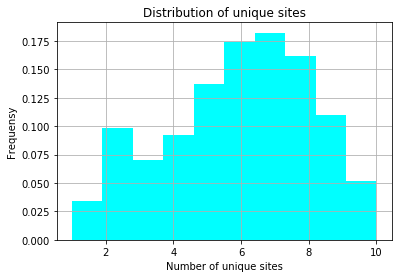

In [13]:
fig, axs = plt.subplots()
axs.grid(True)

plotData = train_data_10users['#unique_sites']

plt.hist(plotData, bins = 10, color='aqua', density=True);

plt.title('Distribution of unique sites');
plt.ylabel('Frequensy');
plt.xlabel('Number of unique sites');

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

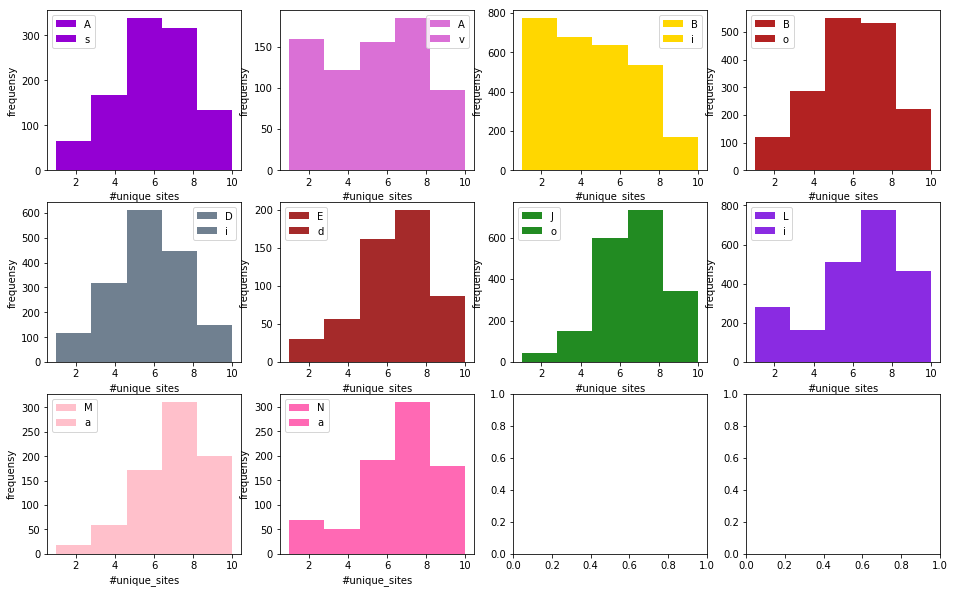

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

plotData = train_data_10users.groupby(['target'])['#unique_sites']

for idx, (col, data) in enumerate(plotData):
    data.plot(kind='hist', ax=axes[int(idx/4), int(idx%4)], bins = 5, color=color_dic[col], legend=True)
    axes[int(idx/4), int(idx%4)].set_xlabel('#unique_sites')
    axes[int(idx/4), int(idx%4)].set_ylabel('frequensy')
    axes[int(idx/4), int(idx%4)].legend(col,loc='best')

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

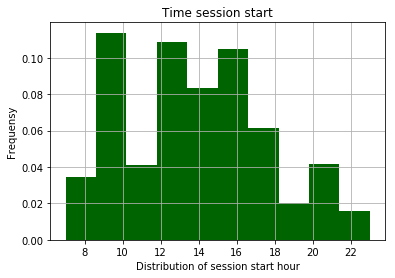

In [15]:
fig, axs = plt.subplots()
axs.grid(True)

plotData = train_data_10users['start_hour']

plt.hist(plotData, bins = 10, color='darkgreen', density=True);

plt.title('Time session start');
plt.ylabel('Frequensy');
plt.xlabel('Distribution of session start hour');

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

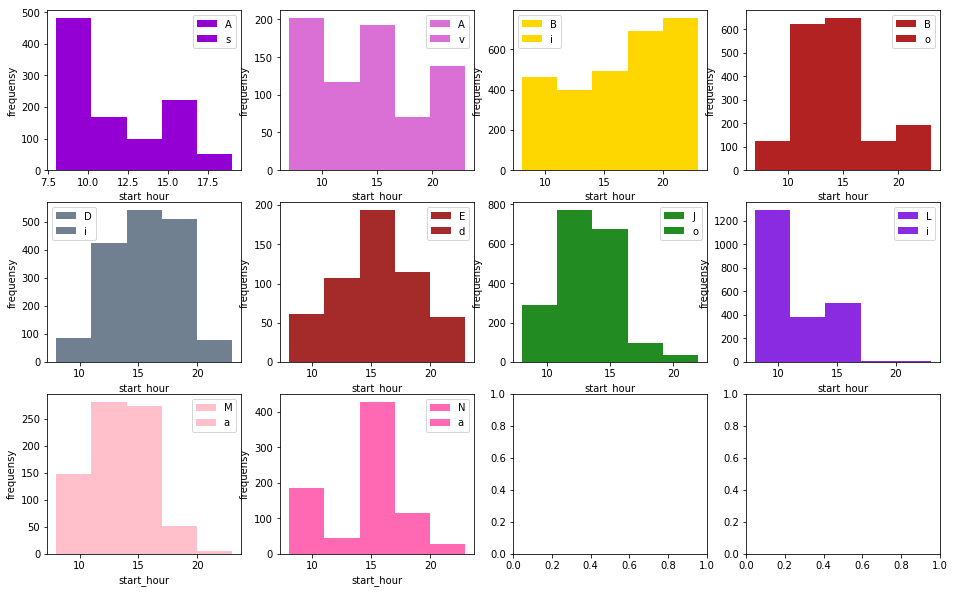

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

plotData = train_data_10users.groupby(['target'])['start_hour']

for idx, (col, data) in enumerate(plotData):
    data.plot(kind='hist', ax=axes[int(idx/4), int(idx%4)], bins = 5, color=color_dic[col], legend=True)
    axes[int(idx/4), int(idx%4)].set_xlabel('start_hour')
    axes[int(idx/4), int(idx%4)].set_ylabel('frequensy')
    axes[int(idx/4), int(idx%4)].legend(col,loc='best')

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

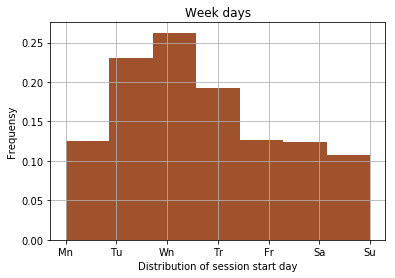

In [17]:
fig, axs = plt.subplots()
axs.grid(True)

plotData = train_data_10users['day_of_week']
plt.hist(plotData, bins = 7, color='sienna', density=True);

plt.title('Week days');
plt.ylabel('Frequensy');
plt.xlabel('Distribution of session start day');
axs.set_xticklabels([0,'Mn', 'Tu','Wn','Tr','Fr','Sa','Su']);

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

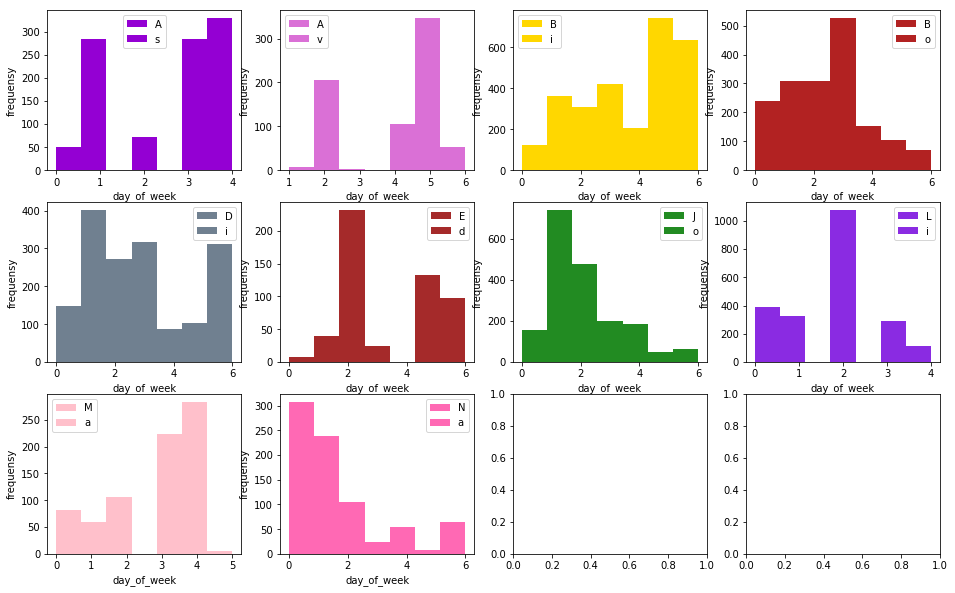

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

plotData = train_data_10users.groupby(['target'])['day_of_week']

for idx, (col, data) in enumerate(plotData):
    data.plot(kind='hist', ax=axes[int(idx/4), int(idx%4)], bins = 7, color=color_dic[col], legend=True)
    axes[int(idx/4), int(idx%4)].set_xlabel('day_of_week')
    axes[int(idx/4), int(idx%4)].set_ylabel('frequensy')
    axes[int(idx/4), int(idx%4)].legend(col,loc='best') 

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

1. Length of sessions distributed by exponential pdf
2. The number of unique sites per session varies in the range of 6-8, which is typical for Ashley, Bob, Dick, Ed, John, Lindsey, Mary-Kate, Naomi
3. Ashley, Bob, Dick, Ed, John, Lindsey, Mary-Kate, Naomi has favorite sites (6-8)
4. Avril and Bill do not have favorite sites
5. Most users log on after 12
6. Ashley, Lindsey, John log on at the morning
7. Bill’s logins intensity lasts all day, but maximum is at the night
8. Most sessions start at the wednesday
9. Ashley, Avril, Bill, Dick, Ed intensively begin their sessions at the weekend
10. John and Naomi begin their sessions at monday and their intensity drops to weekend

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [76]:
with open('site_freq_10users.pkl', 'rb') as site_freq:
    site_freq_10users = pickle.load(site_freq)
with open('site_freq_150users.pkl', 'rb') as site_freq:
    site_freq_150users = pickle.load(site_freq)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [78]:
# 10users

top_dict_10 = sorted(site_freq_10users.items(), key=lambda k: k[1][1], reverse=True)[:10]

top10_freqs = [*map(lambda x: x[1][1], top_dict_10)]
top10_sites = [*map(lambda x: x[0], top_dict_10)]

print(f'\nTop 10 sites:\n {top10_sites} \n\nTop 10 site counts: {top10_freqs}')


Top 10 sites:
 ['dw1.s81c.com', 'www.facebook.com', 'fr-mg42.mail.yahoo.com', 'image.jeuxvideo.com', 'public-api.wordpress.com', 'c04a6e.r.axf8.net', 'platform.linkedin.com', 'www.foxitsoftware.com', 'developer.android.com', 'static.francetv.fr'] 

Top 10 site counts: [6321, 3307, 3083, 3015, 2353, 2130, 2061, 2047, 1835, 1729]


In [79]:
top_dict_150 = sorted(site_freq_150users.items(), key=lambda k: k[1][1], reverse=True)[:10]

top150_freqs = [*map(lambda x: x[1][1], top_dict_150)]
top150_sites = [*map(lambda x: x[0], top_dict_150)]

print(f'\nTop 10 sites:\n{top150_sites} \n\nTop 10 site counts: {top150_freqs}')


Top 10 sites:
['www.facebook.com', 'platform.linkedin.com', 'its.tradelab.fr', 'rp.gwallet.com', 'mail.google.com', 'bits.wikimedia.org', 'ocsp.tcs.terena.org', 'img2.blogblog.com', 'public-api.wordpress.com', 'ba.commentcamarche.net'] 

Top 10 site counts: [19313, 15802, 11880, 11349, 11092, 9951, 9672, 9536, 8389, 8216]


**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

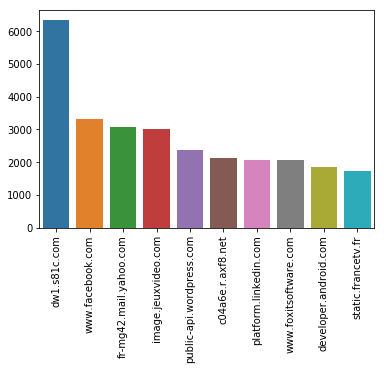

In [14]:
sns.barplot(top10_sites, top10_freqs)
plt.xticks(rotation=90);

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [287]:
# define thresholds for time_diff features
thresholds = [2, 5, 10, 50, 100, 150]


def feature_engineering(dataframe, site_freq, session_length=10):
    '''add new features for features engineering'''   
    
    global thresholds 
    df = dataframe.copy()
    index_dic =  {i:site_freq[i][0] for i in site_freq.keys()}
    #sites = dataframe.columns[:10]
    
    #new features
    df['morming'] = df['start_hour'].apply(lambda x: int(6 <= x < 12) )
    df['evening'] = df['start_hour'].apply(lambda x: int(18 <= x < 24) )
    df['day'] = df['start_hour'].apply(lambda x: int(12 <= x < 18) )
    df['nigth'] = df['start_hour'].apply(lambda x: int(0 <= x < 6) )

#     df['fast_view'] = (df['time_diff1'] + df['time_diff2'] + df['time_diff3'] + df['time_diff4'] + df['time_diff4'] + \
#         df['time_diff5'] + df['time_diff6'] + df['time_diff7'] + df['time_diff8']\
#                                                                + df['time_diff9']).apply(lambda x: int(x < 300))
    for threshold in thresholds:
        df['fast_view_' + str(threshold)] = (df['time_diff1'] + df['time_diff2'] + df['time_diff3'] + df['time_diff4'] +\
        df['time_diff4'] + df['time_diff5'] + df['time_diff6'] + df['time_diff7'] + df['time_diff8'] +\
        df['time_diff9']).apply(lambda x: int(x < threshold))

    df['week_day'] = df['day_of_week'].apply(lambda x: int(6 <= x <= 7) )
    df['work_day'] = df['day_of_week'].apply(lambda x: int(1 <= x <= 5) )
    df['time_un_site'] = (df['session_timespan'] / df['#unique_sites']).apply(lambda x: int(x/60))
    df['social_sites'] = df['site1'].apply(lambda x: 1 if x == (index_dic.get('vk.com')\
                                           or index_dic.get('facebook.com'))  else 0)
        
    # all features
#     features_list = ['morming','evening','day','nigth','week_day','work_day','time_un_site',\
#                      'social_sites','target']

    
    #df['unique_quantity'] = [df.loc[:,'site1':'site10'][col].unique().shape[0] for col in df.loc[:,'site1':'site10'] ]
    df['unique_quantity'] = [*map(len, map(set, df.loc[:,'site1':'site10'].values))]
    
    # Top10 in session
    # replace index from dictionary
    replasment = {k:v[0] for k, v in site_freq.items()}
    top10_index = [*map(replasment.get, top10_sites)]
    # unique set in row
    unque_row_set = map(set, df.loc[:,'site1':'site10'].values)

    def compare_set(input_set):      
        return len(set(top10_index) & input_set)

    df['top10_in_session'] = [*map(compare_set, unque_row_set)]
        
    features_list = ['morming','evening','day','nigth','week_day','work_day','time_un_site',\
                     'social_sites','unique_quantity','top10_in_session','target']\
                  + ['fast_view_' + str(threshold) for threshold in thresholds] 
    
    return df[features_list]

In [255]:
new_features_10users = feature_engineering(train_data_10users, site_freq_10users, session_length=10)
new_features_150users = feature_engineering(train_data_150users, site_freq_150users, session_length=10)

**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [19]:
# Morning day evening night

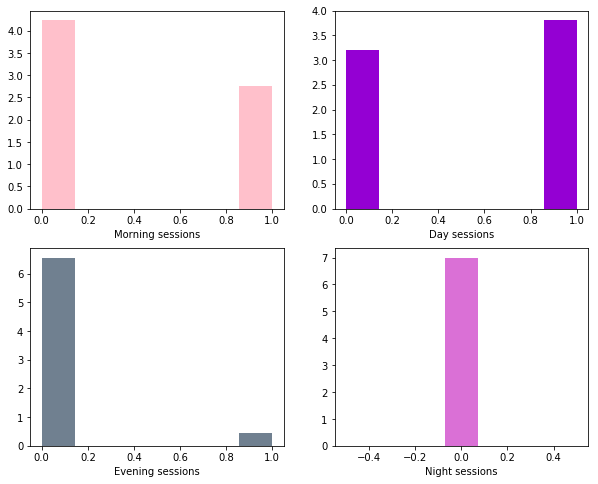

In [56]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

plot_morning = new_features_150users['morming']
plot_evening = new_features_150users['evening']
plot_day = new_features_150users['day']
plot_night = new_features_150users['nigth']

axes[0,0].hist(plot_morning, bins = 7, color='pink', density=True)
axes[0,0].set_xlabel('Morning sessions')
axes[0,1].hist(plot_day, bins = 7, color='darkviolet', density=True)
axes[0,1].set_xlabel('Day sessions')
axes[1,0].hist(plot_evening, bins = 7, color='slategrey', density=True)
axes[1,0].set_xlabel('Evening sessions')
axes[1,1].hist(plot_night, bins = 7, color='orchid', density=True);
axes[1,1].set_xlabel('Night sessions');


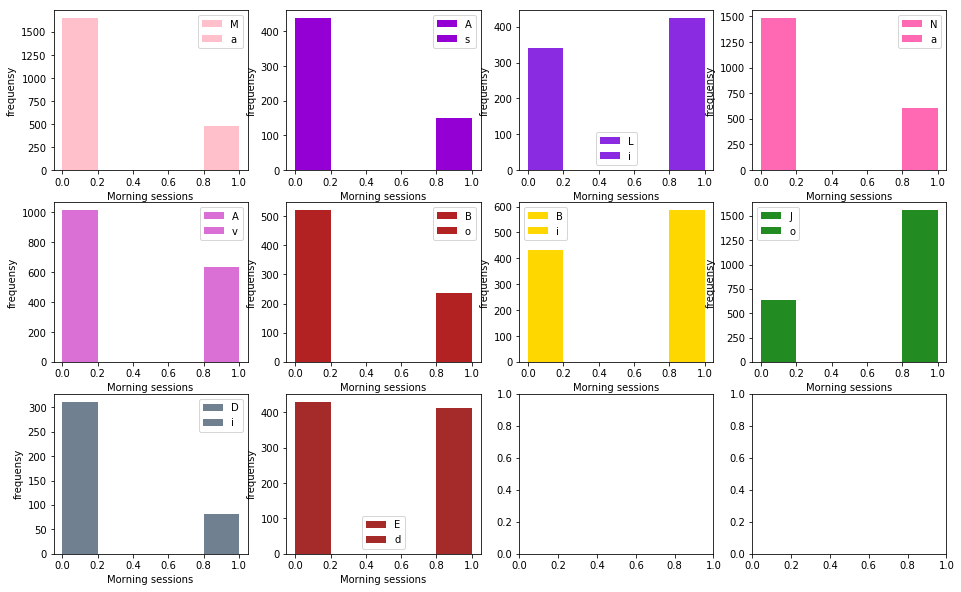

In [20]:
plotData = [*new_features_150users.groupby(['target'])['morming']]
dataPLT = [plotData[i][1] for i in range(10)]
modify_colour = {k:v for k,v in enumerate(color_dic.values())}
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, data in enumerate(dataPLT):
    data.plot(kind='hist', ax=axes[int(idx/4), int(idx%4)], bins = 5, color=modify_colour[idx], legend=True)
    axes[int(idx/4), int(idx%4)].set_xlabel('Morning sessions')
    axes[int(idx/4), int(idx%4)].set_ylabel('frequensy')
    axes[int(idx/4), int(idx%4)].legend(id_name_dict[idx+1],loc='best')

In [21]:
print('Naomi, Mary, Jonh  has morning sessions')

Naomi, Mary, Jonh  has morning sessions


In [22]:
# More prorerly count graphics for day, evening, night, morning

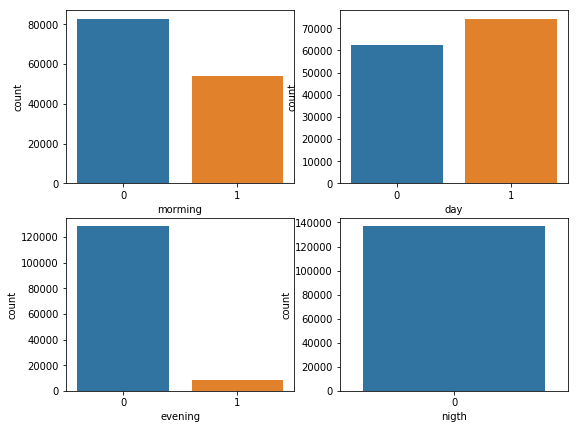

In [46]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9,7))

sns.countplot(new_features_150users['morming'], ax=ax[0,0])
sns.countplot(new_features_150users['day'], ax=ax[0,1])
sns.countplot(new_features_150users['evening'], ax=ax[1,0])
sns.countplot(new_features_150users['nigth'], ax=ax[1,1]);

In [25]:
# Time for unque sessions

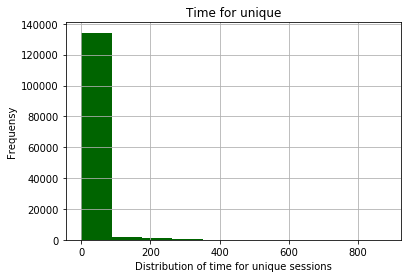

In [47]:
fig, axs = plt.subplots()
axs.grid(True)

plotData = new_features_150users['time_un_site']

plt.hist(plotData, bins = 10, color='darkgreen');

plt.title('Time for unique');
plt.ylabel('Frequensy');
plt.xlabel('Distribution of time for unique sessions');

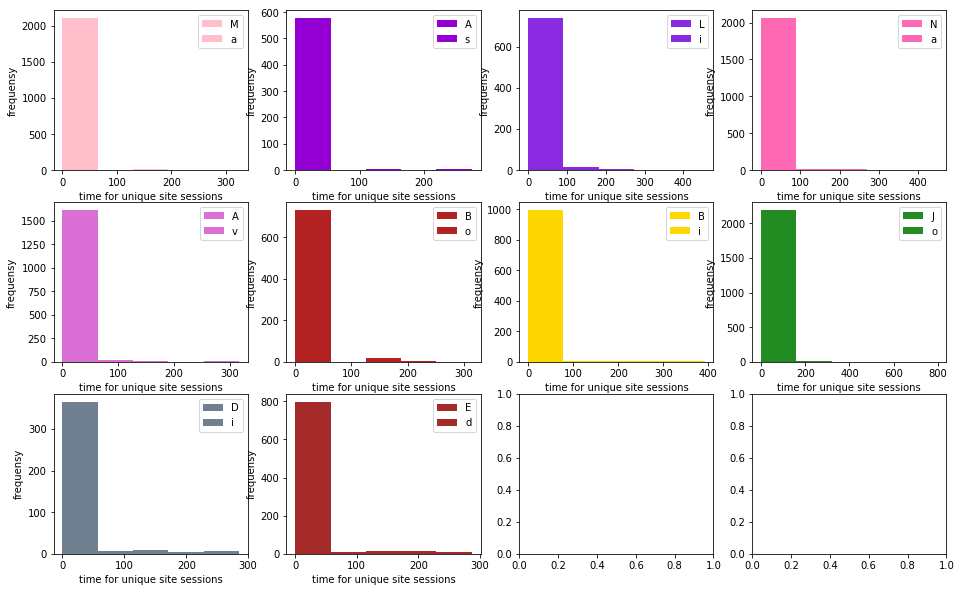

In [27]:
plotData = [*new_features_150users.groupby(['target'])['time_un_site']]
dataPLT = [plotData[i][1] for i in range(10)]
modify_colour = {k:v for k,v in enumerate(color_dic.values())}
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, data in enumerate(dataPLT):
    data.plot(kind='hist', ax=axes[int(idx/4), int(idx%4)], bins = 5, color=modify_colour[idx], legend=True)
    axes[int(idx/4), int(idx%4)].set_xlabel('time for unique site sessions')
    axes[int(idx/4), int(idx%4)].set_ylabel('frequensy')
    axes[int(idx/4), int(idx%4)].legend(id_name_dict[idx+1],loc='best')

In [28]:
print('All users need lees than 300 seconds for unique sites in sessions')

All users need lees than 300 seconds for unique sites in sessions


thresholds:  [2, 5, 10, 50, 100, 150]


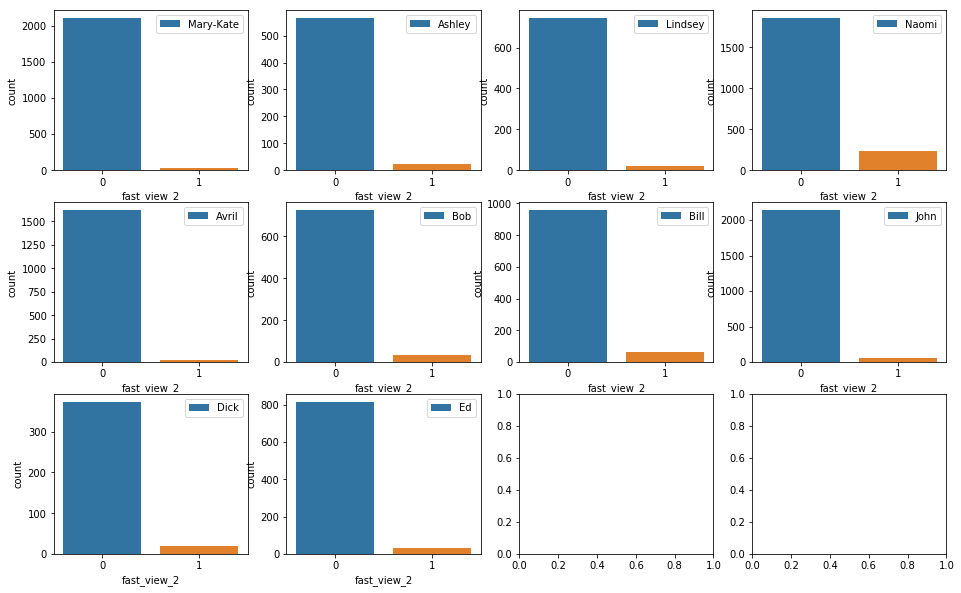

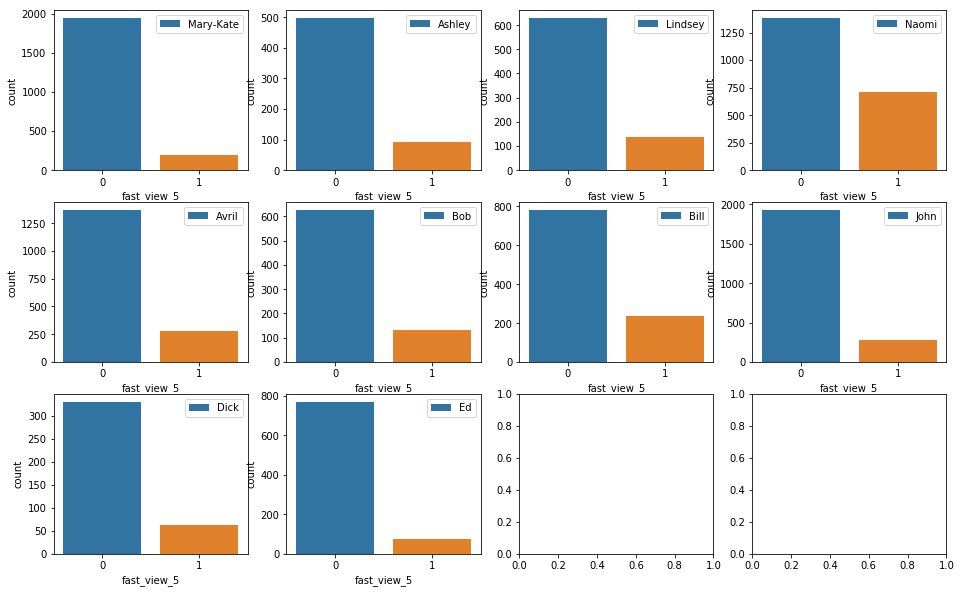

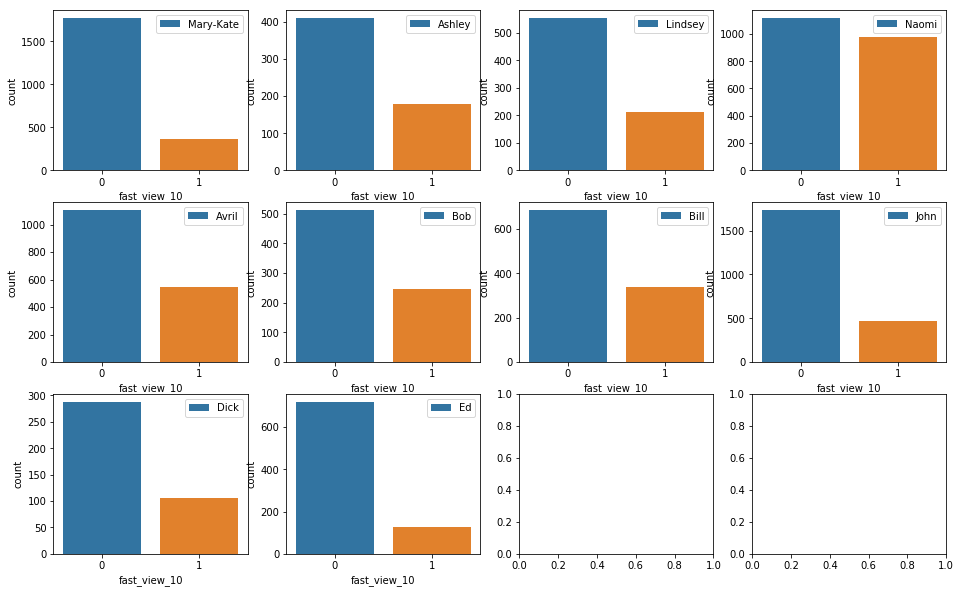

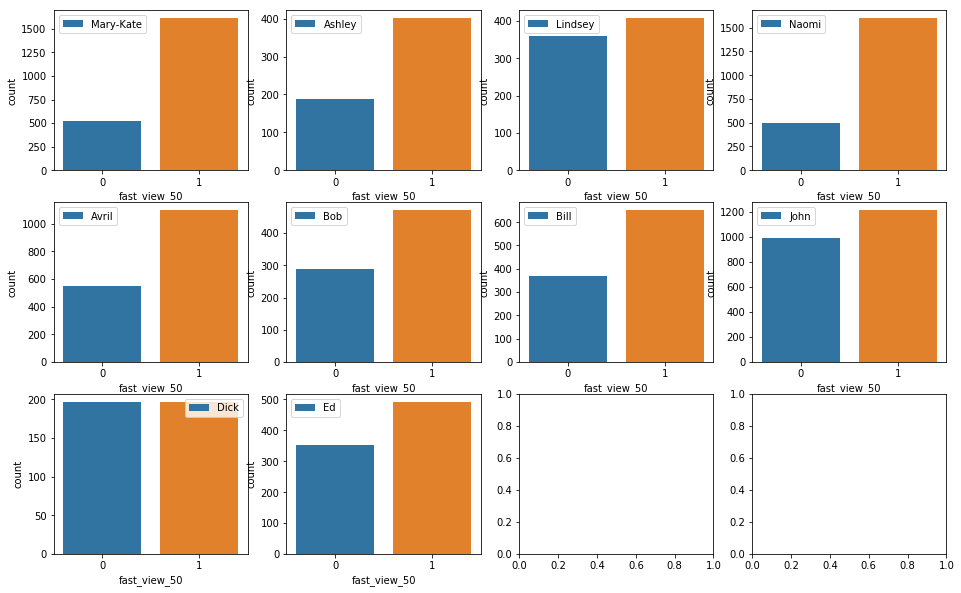

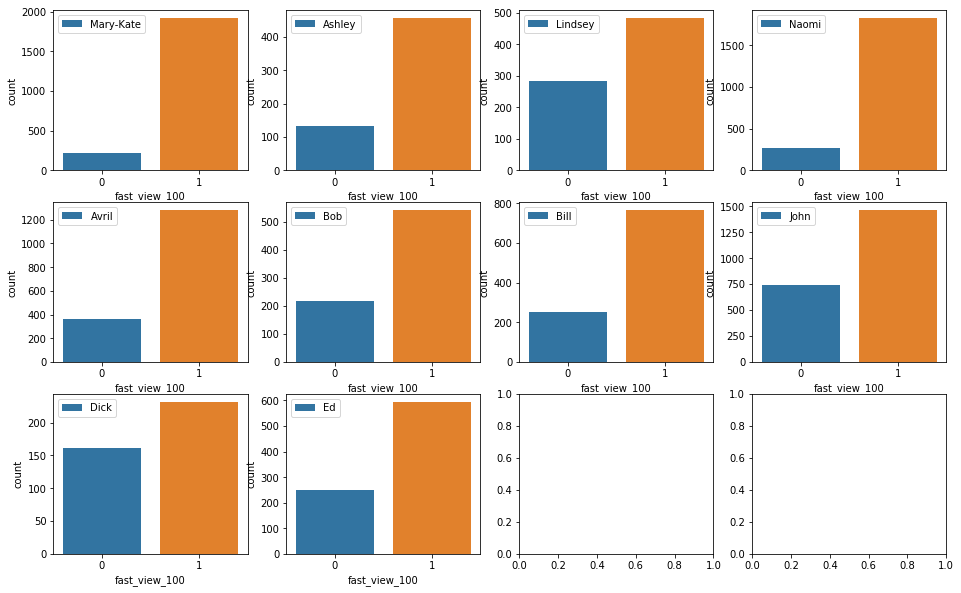

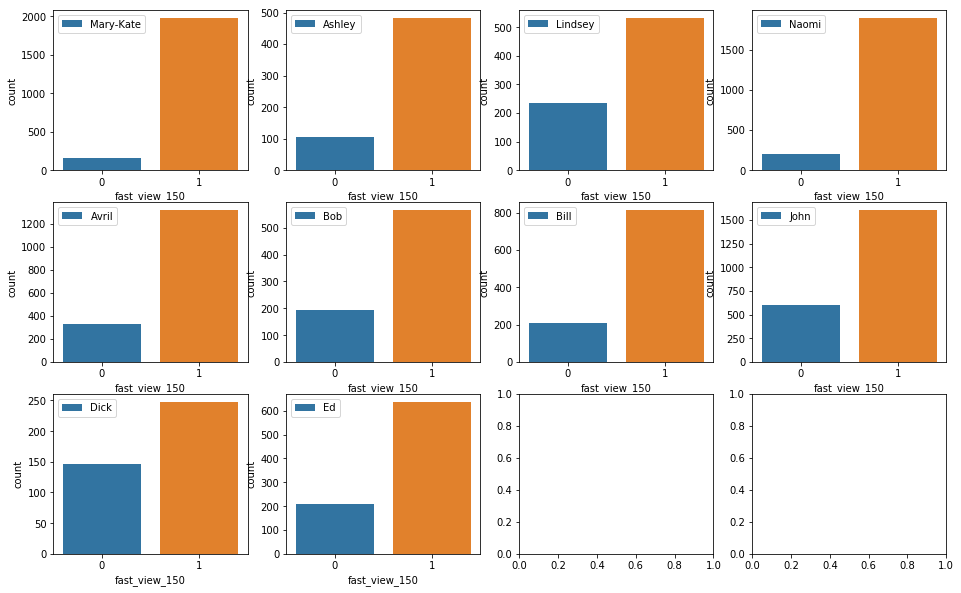

In [73]:
# Site changing for users with variating threshold

print('thresholds: ',thresholds)

def plot_changing_sites(feature):
    '''
    Plotting feature - changing site for all users
    
    need import seaborn as sns
    feature - must be str -> 'fast_view_10'
    '''
    
    plotData = [*new_features_150users.groupby(['target'])[feature]]
    dataPLT = [plotData[i][1] for i in range(10)]
    modify_colour = {k:v for k,v in enumerate(color_dic.values())}

    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

    for idx, data in enumerate(dataPLT):
        sns.countplot(data, ax=axes[int(idx /4), int(idx % 4)], label=id_name_dict[idx+1])
        axes[int(idx /4), int(idx % 4)].legend()   

# Plot with variating threshold
[plot_changing_sites(str(i)) for i in ['fast_view_' + str(threshold) for threshold in thresholds]];

In [71]:
print('Naomi - is the fastest sites viewer for first seconds, she started all sites in session above 200 times\
      - feature spambot')
print('Other users exept Ed started all sites in session in 10 seconds')
print('Dick and Linsey are the slowest users - low priority of changing sites')

Naomi - is the fastest sites viewer for first seconds, she started all sites in session above 200 times      - feature spambot
Other users exept Ed started all sites in session in 10 seconds
Dick and Linsey are the slowest users - low priority of changing sites


In [ ]:
# Unique sites quantity in each sessions for users

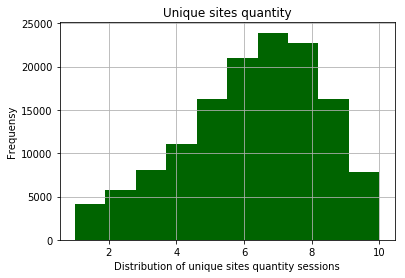

In [262]:
fig, axs = plt.subplots()
axs.grid(True)

plotData = new_features_150users['unique_quantity']

plt.hist(plotData, bins = 10, color='darkgreen');

plt.title('Unique sites quantity');
plt.ylabel('Frequensy');
plt.xlabel('Distribution of unique sites quantity sessions');

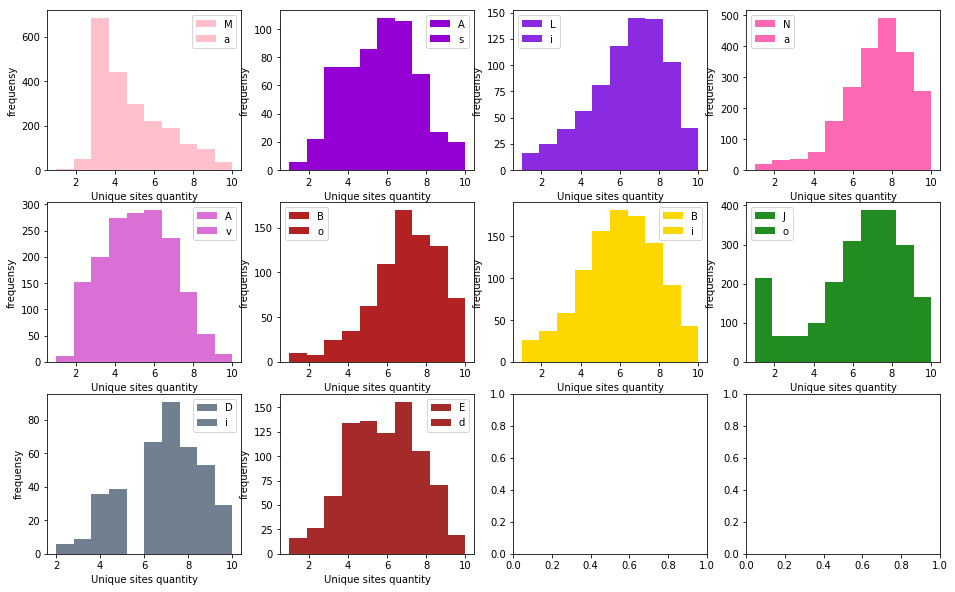

In [143]:
plotData = [*new_features_150users.groupby(['target'])['unique_quantity']]
dataPLT = [plotData[i][1] for i in range(10)]
modify_colour = {k:v for k,v in enumerate(color_dic.values())}
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, data in enumerate(dataPLT):
    data.plot(kind='hist', ax=axes[int(idx/4), int(idx%4)], bins = 10, color=modify_colour[idx], legend=True)
    axes[int(idx/4), int(idx%4)].set_xlabel('Unique sites quantity')
    axes[int(idx/4), int(idx%4)].set_ylabel('frequensy')
    axes[int(idx/4), int(idx%4)].legend(id_name_dict[idx+1],loc='best')

In [145]:
print('All users have close to Normal like distributions')
print('Mary-Kate, Naomi, Bob, Ashley distributions have some kurtusis value, others skewness value')

All users have close to Normal like distributions
Mary-Kate, Naomi, Bob, Ashley distributions have some kurtusis value, others skewness value


In [ ]:
# Top 10 sites in each sessions for users

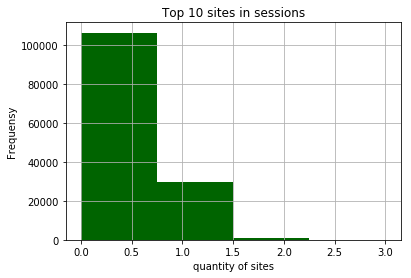

In [299]:
fig, axs = plt.subplots()
axs.grid(True)

plotData = new_features_150users['top10_in_session']

plt.hist(plotData, bins = 4, color='darkgreen');

plt.title('Top 10 sites in sessions');
plt.ylabel('Frequensy');
plt.xlabel('quantity of sites');

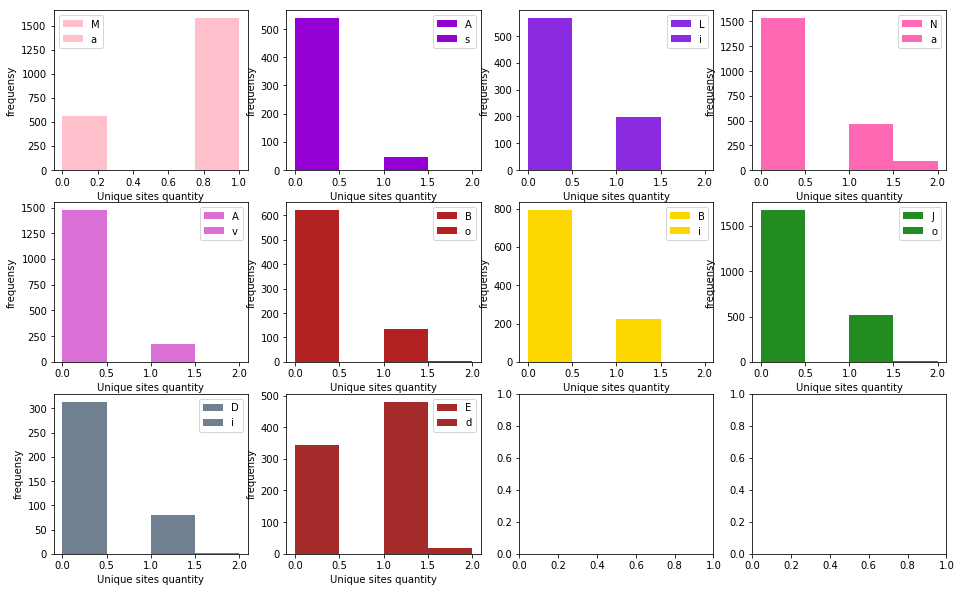

In [292]:
plotData = [*new_features_150users.groupby(['target'])['top10_in_session']]
dataPLT = [plotData[i][1] for i in range(10)]
modify_colour = {k:v for k,v in enumerate(color_dic.values())}
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, data in enumerate(dataPLT):
    data.plot(kind='hist', ax=axes[int(idx/4), int(idx%4)], bins = 4, color=modify_colour[idx], legend=True)
    axes[int(idx/4), int(idx%4)].set_xlabel('Unique sites quantity')
    axes[int(idx/4), int(idx%4)].set_ylabel('frequensy')
    axes[int(idx/4), int(idx%4)].legend(id_name_dict[idx+1],loc='best')

In [300]:
print('Naomi, Ed and Mary-Kate use top10 site more often than others')

Naomi, Ed and Mary-Kate use top10 site more often than others


In [ ]:
# social sites

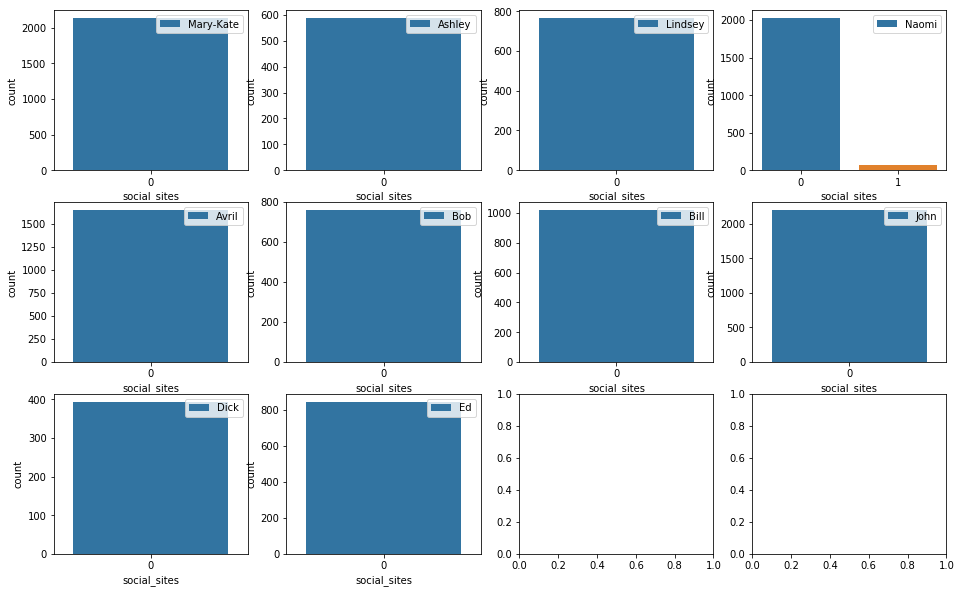

In [69]:
plotData = [*new_features_150users.groupby(['target'])['social_sites']]
dataPLT = [plotData[i][1] for i in range(10)]
modify_colour = {k:v for k,v in enumerate(color_dic.values())}
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, data in enumerate(dataPLT):
    sns.countplot(data, ax=axes[int(idx /4), int(idx % 4)], label=id_name_dict[idx+1])
    axes[int(idx /4), int(idx % 4)].legend()   

In [38]:
print('Only Naomy log to facbook or vk in the mornig')

Only Naomy log to facbook or vk in the mornig


**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [305]:
session_length = 10

selected_features_10users = ['site' + str(index + 1) for index in range(session_length)] + \
            ['time_diff' + str(index + 1) for index in range(session_length - 1)] + \
            ['unique_sites', 'start_hour', 'day_of_week','time_un_site','unique_quantity','top10_in_session','user_id'] + \
            ['fast_view_' + str(threshold) for threshold in thresholds]

selected_features_150users = ['site' + str(index + 1) for index in range(session_length)] + \
            ['time_diff' + str(index + 1) for index in range(session_length - 1)] + \
            ['unique_sites', 'start_hour', 'day_of_week','time_un_site','unique_quantity','top10_in_session','user_id'] + \
            ['fast_view_' + str(threshold) for threshold in thresholds]

In [306]:
with open(os.path.join('selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, protocol=2)

with open(os.path.join('selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, protocol=2)

In [ ]:
# Old code for debug

In [ ]:
# # Functions

# def incomplete_condition(user_data_eval, session_length):
#     '''Condition for determining incomplete session'''
#     if not user_data_eval.shape[0] % session_length == 0:   
#         # Fill zeros for incomplete session
#         for index in range( user_data_eval.shape[0], (user_data_eval.shape[0] // session_length + 1)*session_length ):
#             user_data_eval.loc[index] = [0, 0]
            
# def path_to_csv(path_to_csv_files, PATH_TO_PROJECT='~/geekhubds/HW09'):
#     ''' Path to data - csv files'''
#     # File operations
#     file_quant = len(glob(path_to_csv_files))
#     file_names = [file for file in glob(path_to_csv_files)]
#     file_length = len(file_names)
#     # Import csv files
#     user_data = [pd.read_csv(os.path.join(PATH_TO_PROJECT,file)) for file in file_names]
#     return user_data
   
# def path_to_plc(path_pckl_file):
#     ''' Path to data - pckl file'''
#     with open(path_pckl_file, 'rb') as site_freq:
#         site_freq = pickle.load(site_freq)
#     def replace_func(site_freq):
#         '''Creation replace dic from site freq dictionary'''
#         return {site:site_freq.get(site)[0] for site in site_freq.keys()}
#     return site_freq, replace_func(site_freq)

# path_to_csv_files = '3users\*'
# path_pckl_file = 'site_freq_3users.pkl'
# session_length = 10
    

# # Creation Dataframe and columns
# site_numeration = ['site' + str(index + 1) for index in range(session_length)] + \
#                   ['time_diff' + str(index + 1) for index in range(session_length - 1)] + \
#                   ['session_timespan','unique_sites', 'start_hour', 'day_of_week','user_id']

#     # Ininitial dataframe and user id
# resultData = pd.DataFrame(columns=(site_numeration))

# #all_data_result = []
# user_id = 0

# # Import csv files 
# user_data = path_to_csv(path_to_csv_files) 

# # Import  dictionary  and replace rule
# site_freq_users_all, replasment = path_to_plc(path_pckl_file)
             
# #User id value
# user_id = user_id + 1 
#         # Copy of daraframe for main algorytm
# user_data_eval = user_data[0].copy() 
# #Time convert to datatime
# user_data_eval['timestamp'] = user_data_eval['timestamp']\
#                           .apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ))

In [ ]:
# #User id value
# user_id = user_id + 1 
#         # Copy of daraframe for main algorytm
# user_data_eval = user_data[1].copy() 

# #Time convert to datatime
# user_data_eval['timestamp'] = user_data_eval['timestamp']\
#                           .apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ))

In [ ]:

# # Condition for determining incomplete session
# incomplete_condition(user_data_eval, session_length)

#     # Main alhortm of replacing str sites for numbers
# session_items = int( user_data_eval.shape[0] / session_length )

# # sites
# all_sessions = user_data_eval['site'].values.reshape(session_items,-1)
# # time
# #all_time_sessions = user_data_eval['timestamp'].values.reshape(session_items,-1)
# all_time_sessions = user_data_eval['timestamp'].values.astype('datetime64[s]')\
#         .astype(datetime.datetime).reshape(session_items,-1)

# all_time_sessions_null = [*map(np.trim_zeros,all_time_sessions)]

# # Time difference evaluating
# diff_seconds = [*map(lambda session: [(j-i).seconds for i, j in zip(session, session[1:])], all_time_sessions_null)]

# # Add droped 0 
# for index, items in enumerate(diff_seconds):
#     if len(items) != session_length: diff_seconds[index] = (items + [0] * (session_length - 1 - len(items)))
        
# # Session_timespan
# session_timespan = [*map(lambda x: [(x[-1] - x[0]).seconds], all_time_sessions_null)]

# # Unique sites
# unique_sites = [*map(lambda x: [np.unique(x).shape[0]], map(np.trim_zeros,all_sessions))]

# # Start session
# #start_hour = [*map(lambda x: [sorted(x)[0].hour],all_time_sessions_null)]
# start_hour = [*map(lambda x: [x[0].hour],all_time_sessions_null)]

# # Day of week
# #day_of_week = [*map(lambda x: [sorted(x)[0].weekday()],all_time_sessions_null)]
# day_of_week = [*map(lambda x: [x[0].weekday()],all_time_sessions_null)]

# # User ID
# target_user = [ [user_id] for _ in np.arange(session_items)]


# # Stack data
# all_data = np.hstack((all_sessions,diff_seconds,session_timespan,unique_sites,start_hour,day_of_week,target_user))

# # resultData add data
# resultData = resultData.append(pd.DataFrame(data=all_data, columns=site_numeration),ignore_index=True)
# #resultData = resultData.fillna(0)

# #resultData

In [ ]:



# #Replacing site_id in column and delete NANs
# site_numebers = ['site' + str(index + 1) for index in range(session_length)]
# for site in site_numebers:
#     resultData[site] = resultData[site].map(replasment.get)
# resultData = resultData.fillna(0).astype(int)
    
#resultData#, site_freq_users_all

In [ ]:
# def invert_dict_nonunique(d):
#     newdict = {}
#     for k, v in d.items():
#         newdict.setdefault(v, []).append(k)
#     return newdict

# def toTime(timeStr):
#     '''conver Str time to datatime foormat'''
#     return datetime.datetime.strptime( timeStr, "%Y-%m-%d %H:%M:%S" )

# def delete_null_dictkeys(d):
#     '''Delete 0 - keys in dictionary'''
#     if 0 in d:
#         del d[0]

# def adding_dicts(A,B):
#     '''Adding dicts values'''
#     result = {}
#     for d in (A, B):
#         for key in d:
#             try:
#                 result[key] += d[key]
#             except KeyError:
#                 result[key] = d[key]
#     return result 

In [ ]:
# # Dic with default values
# default_dict = { key : 0 for key in replasment.keys()}

# # Session - time && site splitting for sessions
# all_time_and_sites = user_data_eval.values.reshape(session_items,-1)

# # Dict -> {time:site} for each pair
# dict_time_sites = [*map(lambda x: dict(zip(*[iter(x)] * 2)), all_time_and_sites)]

# # Invert dic with multiply values
# dict_sites_time = [*map(invert_dict_nonunique, dict_time_sites)]

# # Time mutation in dictionary
# dict_sites_delta = map(lambda d: {key:(d[key][-1] - d[key][0]).seconds if len(d[key]) != 1 else 0\
#                                     for key in d.keys()},dict_sites_time)
# # update dictionary
# #[result_dict.update(d) for d in dict_sites_delta]
# dict_time = [*map(lambda x: adding_dicts(default_dict,x), dict_sites_delta)]

# # Delete 0 keys 
# [*map(delete_null_dictkeys,dict_time)]

# # Session_timespan
# session_timespan = [*map(lambda x: (x[-2] - x[0]).seconds, all_time_and_sites)]

# # Unique_sites
# unique_sites = [*map(lambda x: len(x), dict_sites_time)]

# dict_time, session_timespan, unique_sites